In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr

# Example

To go back to the example from the lecture we load the data and plot it alongside the two smoothed versions

In [9]:
d = pd.read_csv('smoothing_example_data.csv', index_col=0)

Annual: r=0.031, (p=0.167825)
10 yr : r=0.057, (p=0.010530)


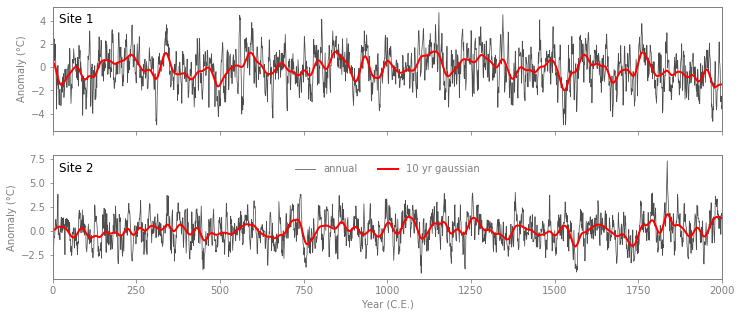

In [10]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 5))

sigma_f = 10

for i, (ax, c) in enumerate(zip(axes, d.columns)):
    ax.plot(d.index, d[c], '0.3', lw=0.75, label='annual')
    ax.plot(d.index, gaussian_filter1d(d[c], sigma_f), 'r', lw=2.0, label='%u yr gaussian' % sigma_f)
    ax.set_ylabel('Anomaly (°C)')
    ax.set_xlim(0, 2000)
    ax.text(0.01, 0.95, 'Site %u' %(i+1), va='top', ha='left', transform=ax.transAxes, color='k', fontsize=12)
    
axes[1].legend(loc='upper center', ncol=2)
axes[-1].set_xlabel('Year (C.E.)')


print('Annual: r=%.3f, (p=%.6f)' % pearsonr(d['y1'], d['y2']))
print('%u yr : r=%.3f, (p=%.6f)' % (sigma_f, *pearsonr(gaussian_filter1d(d['y1'], sigma_f), 
                                                 gaussian_filter1d(d['y2'], sigma_f))))

# Save correlation value for later
corr = pearsonr(gaussian_filter1d(d['y1'], sigma_f), 
                gaussian_filter1d(d['y2'], sigma_f))[0]

To generate a more relistic null-distribution we use again AR(1) processes. 

In [11]:
from ar1 import fit_ar1, sample_ar1

First we estimate the auto-correlation as well as the standard deviations of the AR(1) processes from the data.

We see that both time series have very high auto-correlation.

In [13]:
ar_y1 = fit_ar1(d.iloc[:,0].values - d.iloc[:,0].values.mean())
ar_y2 = fit_ar1(d.iloc[:,1].values - d.iloc[:,0].values.mean())

print('y1 (phi, sigma_e):', ar_y1)
print('y2 (phi, sigma_e):', ar_y2)

y1 (phi, sigma_e): (0.7576081560923484, 1.022319324942635)
y2 (phi, sigma_e): (0.7341010153938707, 1.0029721172391357)


We than generate a large number of samples from AR(1) processes with these parametres that have the same number of observations as the original data. These we correlate with each other to generate the null-distribution we compare against.

In [15]:
n_obs = d.shape[0]
n_samples = 10000

y1_samples = gaussian_filter1d(sample_ar1(n_obs, *ar_y1, n_samples), sigma_f)
y2_samples = gaussian_filter1d(sample_ar1(n_obs, *ar_y2, n_samples), sigma_f)
r_null_dist = np.array([pearsonr(y1i, y2i)[0] for y1i, y2i in zip(y1_samples, y2_samples)])

Lets plot the the null distribution together with the correlation of the smoothed data.

Text(0.5, 1.0, 'Empirical null distribution (smoothed AR(1))')

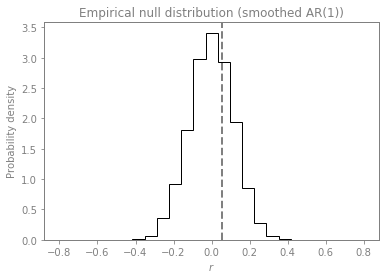

In [17]:
fig, ax = plt.subplots()
ax.hist(r_null_dist, density=True, bins=25, range=(-0.8, 0.8), histtype='step', color='k')
ax.axvline(corr, lw=2.0, ls='dashed')
ax.set_xlabel('$r$')
ax.set_ylabel('Probability density')
ax.set_title('Empirical null distribution (smoothed AR(1))')

And lets calculate the empirical p-value of this correlation

In [ ]:
p_val = np.mean(np.abs(r_null_dist) >= corr)
print('r=%.2f, p=%.2f' % (corr, p_val))